In [1]:
#Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime as dt

from sklearn.model_selection import train_test_split

from collections import defaultdict

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# read dataset
url = "https://raw.githubusercontent.com/denindrap23/Machine-Learning/refs/heads/main/Predict-Customer-Clicked-Ads-Classification%20by%20using-Machine-Learning/dataset/Clicked%20Ads%20Dataset.csv"

df = pd.read_csv(url)
df.head()

,Unnamed: 0,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Timestamp,Clicked on Ad,city,province,category
0,0,68.95,35,432837300.0,256.09,Perempuan,3/27/2016 0:53,No,Jakarta Timur,Daerah Khusus Ibukota Jakarta,Furniture
1,1,80.23,31,479092950.0,193.77,Laki-Laki,4/4/2016 1:39,No,Denpasar,Bali,Food
2,2,69.47,26,418501580.0,236.50,Perempuan,3/13/2016 20:35,No,Surabaya,Jawa Timur,Electronic
3,3,74.15,29,383643260.0,245.89,Laki-Laki,1/10/2016 2:31,No,Batam,Kepulauan Riau,House
4,4,68.37,35,517229930.0,225.58,Perempuan,6/3/2016 3:36,No,Medan,Sumatra Utara,Finance


# 1. Data Preparation

## 1.1 Data Null

In [3]:
# Hitung null
null_count = df.isnull().sum()

# Hitung persentase null
null_percentage = (null_count / len(df) * 100).round(2)

# Hitung non-null count
non_null_count = df.notnull().sum()

dtypes = df.dtypes

info_df = pd.DataFrame({
    'Data Type': dtypes,
    'Non-Null Count': non_null_count,
    'Null Count': null_count,
    'Null Percentage (%)': null_percentage
})

info_df

,Data Type,Non-Null Count,Null Count,Null Percentage (%)
Unnamed: 0,int64,1000,0,0.0
Daily Time Spent on Site,float64,987,13,1.3
Age,int64,1000,0,0.0
Area Income,float64,987,13,1.3
Daily Internet Usage,float64,989,11,1.1
Male,object,997,3,0.3
Timestamp,object,1000,0,0.0
Clicked on Ad,object,1000,0,0.0
city,object,1000,0,0.0
province,object,1000,0,0.0


In [4]:
df['Daily Time Spent on Site'].fillna(df['Daily Time Spent on Site'].mean(),inplace=True)
df['Area Income'].fillna(df['Area Income'].mean(),inplace=True)
df['Daily Internet Usage'].fillna(df['Daily Internet Usage'].mean(),inplace=True)
df['Male'].fillna(df['Male'].mode()[0],inplace=True)

## 1.2 Extract Datetime

In [5]:
## UDF for Feature Extraction
def extract_day_of_week(time):
    return dt.strptime(time,'%m/%d/%Y %H:%M').weekday()

def extract_day_of_month(time):
    return dt.strptime(time,'%m/%d/%Y %H:%M').day

def extract_month(time):
    return dt.strptime(time,'%m/%d/%Y %H:%M').month

df['day_of_week'] = df['Timestamp'].apply(extract_day_of_week)
df['day_of_month'] = df['Timestamp'].apply(extract_day_of_month)
df['month'] = df['Timestamp'].apply(extract_month)

df = df.drop(labels=['Timestamp'],axis=1)

df.rename(columns={'Male': 'Gender'}, inplace=True)

## 1.3 Drop Irrelevant Feature

In [6]:
df = df.drop(columns=['Unnamed: 0'])

## 1.4 Statistical Summaries

In [7]:
# numerical statistic
numerical_stat = ['Age', 'Daily Time Spent on Site', 
                  'Area Income', 'Daily Internet Usage']

desc_nums = df[numerical_stat].describe().round(3).T

for i, col in enumerate(numerical_stat):
    desc_nums.loc[col, 'no_unique'] = df[col].nunique()

desc_nums['no_unique'] = desc_nums['no_unique'].astype(int)
desc_nums

,count,mean,std,min,25%,50%,75%,max,no_unique
Age,1000.0,3.600900e+01,8.786000e+00,19.00,2.900000e+01,3.500000e+01,4.200000e+01,6.100000e+01,43
Daily Time Spent on Site,1000.0,6.493000e+01,1.574100e+01,32.60,5.154500e+01,6.778000e+01,7.835200e+01,9.143000e+01,891
Area Income,1000.0,3.848647e+08,9.346585e+07,97975500.00,3.298201e+08,3.975088e+08,4.566932e+08,5.563936e+08,988
Daily Internet Usage,1000.0,1.798640e+02,4.362800e+01,104.78,1.390180e+02,1.810650e+02,2.182880e+02,2.670100e+02,956


In [8]:
# categorical statistic

categorical_stat = df.select_dtypes('object')

desc_cats = categorical_stat.astype(str).describe().T
desc_cats['frac_top'] = desc_cats['freq'] * 100 / df.shape[0]
desc_cats

,count,unique,top,freq,frac_top
Gender,1000,2,Perempuan,521,52.1
Clicked on Ad,1000,2,No,500,50.0
city,1000,30,Surabaya,64,6.4
province,1000,16,Daerah Khusus Ibukota Jakarta,253,25.3
category,1000,10,Otomotif,112,11.2


# 2. Exploratory Data Analysis

## 2.1 Clicked on Ad Distribution

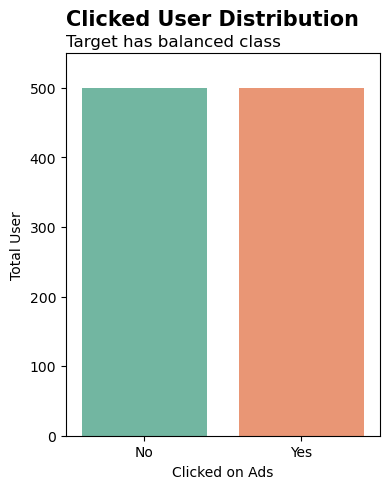

In [9]:
# Clicked on Ad Distribution
counts = df['Clicked on Ad'].value_counts()

plt.figure(figsize=(4,5))

sns.barplot(x=counts.index,y=counts, palette="Set2")

plt.text(x=-0.5, y=590, s="Clicked User Distribution", 
         fontsize=15, fontweight='bold')
plt.text(x=-0.5, y=560, s="Target has balanced class", 
         fontsize=12)

plt.xlabel('Clicked on Ads', fontsize=10)
plt.ylabel('Total User', fontsize=10)

plt.ylim(0,550)
plt.tight_layout()
plt.savefig('clicked_user_distribution.png', dpi=200)
plt.show()

Data yang akan kita gunakan ternyata memiliki label yang cukup balanced (seimbang) sehingga kita tidak perlu melakukan preprocessing untuk mengatasi imbalanced class.

## 2.2 Daily Internet Usage

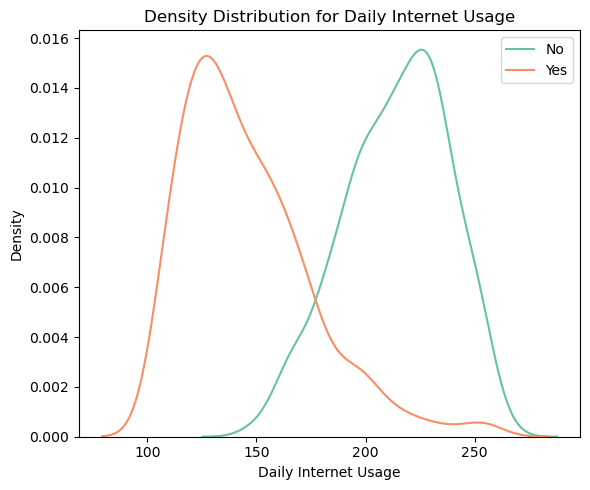

In [10]:
# label
yes = df[df['Clicked on Ad'] == 'Yes']
no = df[df['Clicked on Ad'] == 'No']

# Daily Internet UsageDistribution
plt.figure(figsize=(6,5))

sns.kdeplot(no['Daily Internet Usage'],label='No', color = "#66c2a5")
sns.kdeplot(yes['Daily Internet Usage'],label='Yes', color = "#fc8d62")

plt.title('Density Distribution for Daily Internet Usage')
plt.legend()
plt.tight_layout()
plt.savefig('daily_internet_usage_distribution.png', dpi=200)
plt.show()

Dari EDA di atas kita akan melihat distribusi penggunaan internet harian (dalam satuan menit). Terlihat ada hal menarik pada distribusi berikut. Bahwa potensi user dalam menclick suatu product lebih tinggi untuk user yang jarang menggunakan internet dibandingkan yang sering menggunakan internet.

Hal ini bisa mengindikasikan bahwa user yang jarang menggunakan internet cenderung lebih memperhatikan adanya iklan disuatu website.

## 2.3 Daily Time Spent on Site

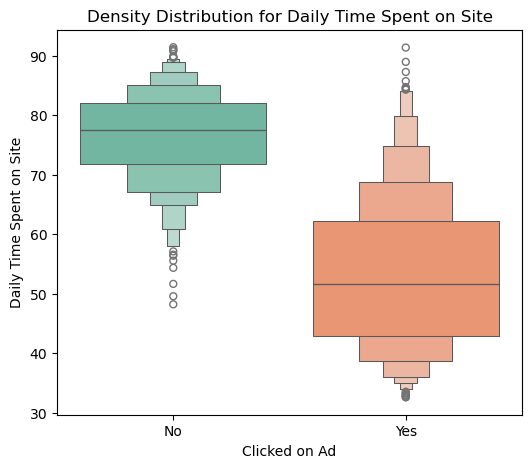

In [11]:
plt.figure(figsize=(6,5))

sns.boxenplot(x=df['Clicked on Ad'],y=df['Daily Time Spent on Site'], palette="Set2")

plt.title('Density Distribution for Daily Time Spent on Site')
plt.savefig('daily_time_spent_distribution.png', dpi=200)
plt.show()

Karena penggunaan internet memiliki distribusi yang unik. Kita ingin mencoba menampilkan bagaimana behaviour seseorang dalam sebuah website. Bedasarkan EDA di atas, ternyata penggunaan internet dan lamanya user pada sebuah website memiliki distribusi yang mirip. Yaitu, potential user dapat ditemukan ketika berkunjung pada sebuah website hanya sebentar.

## 2.4 Age

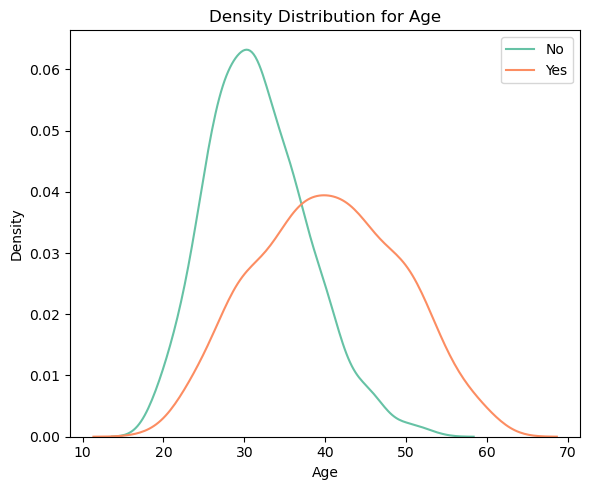

In [12]:
# Age Distribution
plt.figure(figsize=(6,5))

sns.kdeplot(no['Age'],label='No', color = "#66c2a5")
sns.kdeplot(yes['Age'],label='Yes', color = "#fc8d62")

plt.title('Density Distribution for Age')
plt.legend()
plt.tight_layout()
plt.savefig('age_distribution.png', dpi=200)
plt.show()

Dari visualisasi tentang umur ternyata market yang potential justru terdapat pada orang tua. Mungkin karena anak muda jauh lebih teliti dan selektif ketika browsing internet. Dan anak muda sangat mudah menyadari ketika ada iklan di sebuah website.

## 2.5 Internet Usage vs Time Spent on Site

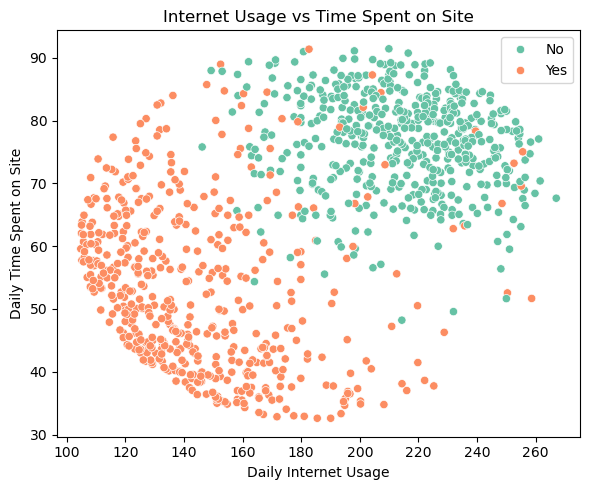

In [13]:
# Internet Usage vs Time Spent on Site
plt.figure(figsize=(6,5))
sns.scatterplot(x=df['Daily Internet Usage'],y=df['Daily Time Spent on Site'],hue=df['Clicked on Ad'], palette="Set2")

plt.title('Internet Usage vs Time Spent on Site')
plt.legend()
plt.tight_layout()
plt.savefig('internet_usage_vs_time_spent.png', dpi=200)
plt.show()

Setelah mengetahui adanya kemiripan antara penggunaan internet dan lamanya berkunjung pada sebuah website. Kita mencoba melihat hubungan 2 buah feature tersebut dengan targetnya.

Ternyata berdasarkan plot tersebut kita bisa tahu bahwa penggunaan internet dan lamanya visit sebuah site dapat terbagi menjadi 2 buah segment yaitu active user dan non active user.

2 Segment tersebut dapat menjadi feature yang cukup erat dengan potensi seseorang click sebuah iklan atau tidak. Dapat dilihat pada visualisasi di atas ternyata, Active user cenderung tidak suka mengclick sebuah iklan dibandingkan non Active User.

Kesimpulannya, kita bisa optimalkan sistem advertisment kita terhadap user-user yang tidak aktif menggunakan internet.

## 2.6 Correlation

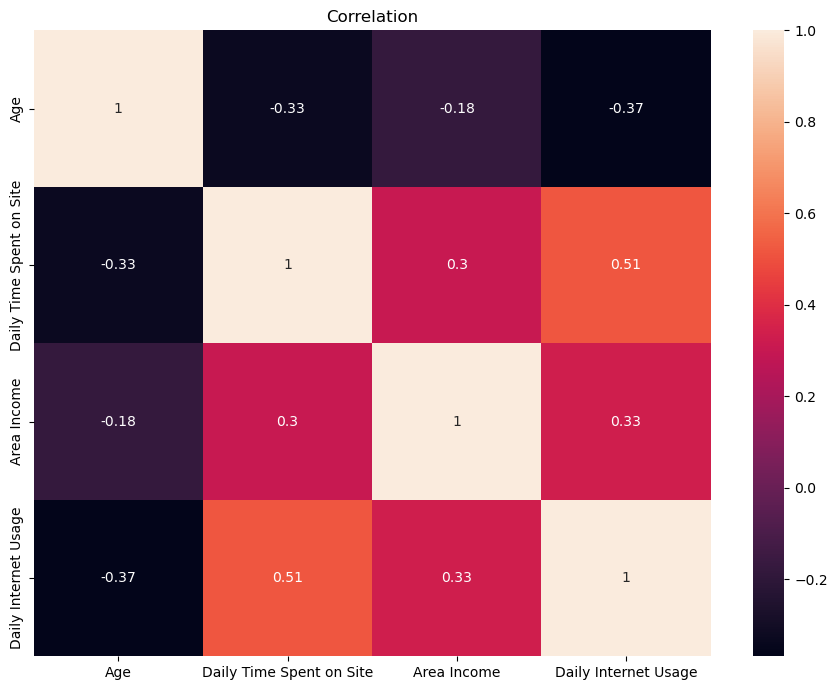

In [14]:
# Correlation
plt.figure(figsize=(9,7))
sns.heatmap(df[numerical_stat].corr(),annot=True)

plt.title('Correlation')
plt.tight_layout()
plt.savefig('correlation.png', dpi=200)
plt.show()

Dari korelasi di atas kita tidak menemukan adanya multicorrelation (korelasi antar variable) sehingga kita dapat menggunakan semua feature untuk dilakukan modeling. Namun dengan menggunakan korelasi pearson kita tidak dapat mengetahui hubungan antara feature dengan targetnya. Maka di bawah ini kita akan menggunakan dython dalam menghitung hubungan antar feature dengan targetnya.

## 2.7 Correlation using Dython

In [15]:
pip install dython

Note: you may need to restart the kernel to use updated packages.


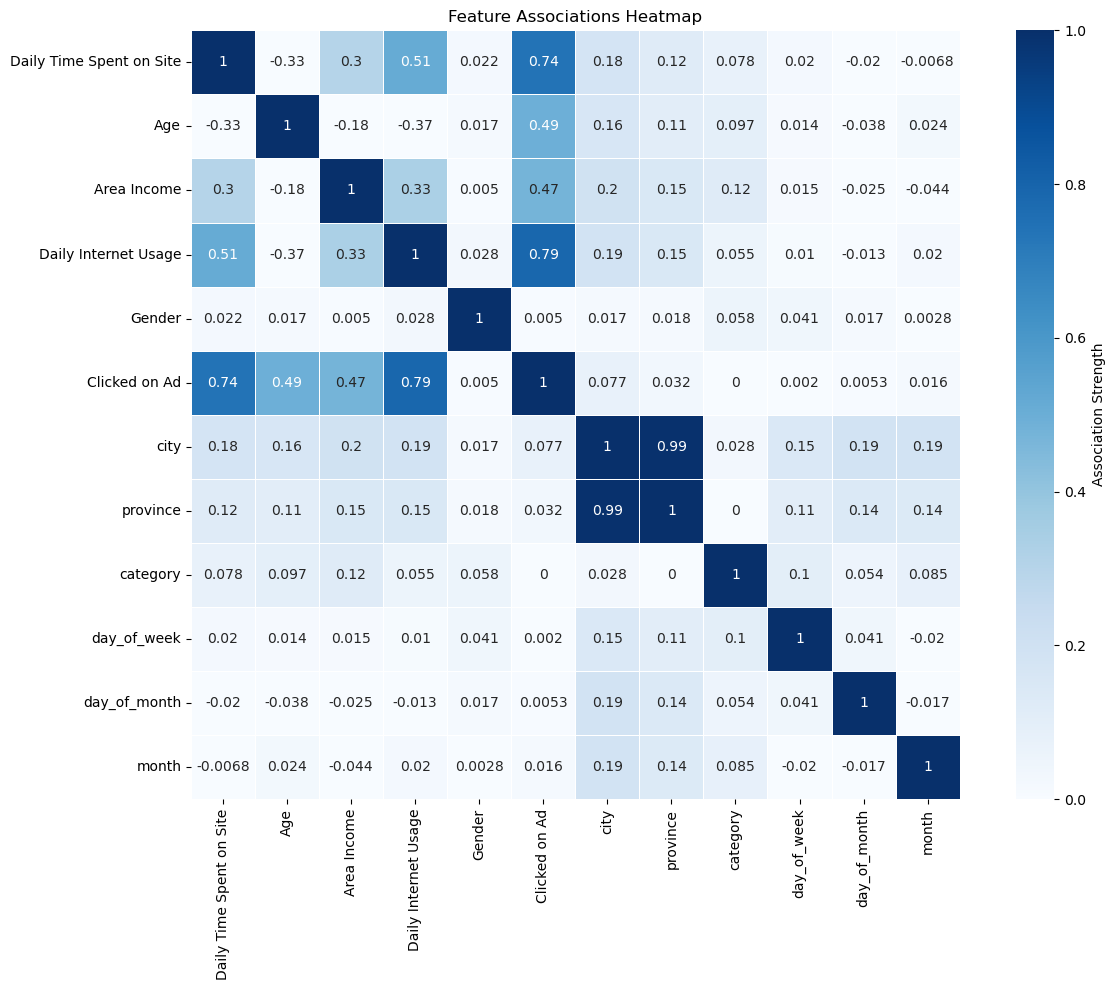

In [16]:
from dython.nominal import associations
import seaborn as sns
import matplotlib.pyplot as plt

assoc = associations(df, nominal_columns='auto', plot=False)

plt.figure(figsize=(13,10))

sns.heatmap(assoc['corr'], annot=True, cmap='Blues', vmin=0, vmax=1,
            square=True, linewidths=0.5, cbar_kws={'label': 'Association Strength'})

plt.title('Feature Associations Heatmap')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Berdasarkan correlation plot menggunakan dython di atas, kita akan fokus pada feature `Clicked on Ad` saja. Karena variable tersebut adalah target yang akan kita gunakan.

Feature yang cukup berhubungan dengan target:
- Daily Internet Usage
- Daily Time Spent on Site
- Age
- Area Income

Correlation plot ini bisa menjadi panduan dalam melakukan modeling

# 3. Modeling

Tahapan selanjutnya adalah tahapan modeling, pada tahapan kali ini kita akan membangun sebuah model dengan tingkat akurasi yang tinggi. Kita akan menggunakan metrics `accuracy` dikarenakan jumlah kategori pada target yang kita gunakan seimbang.

Berikut adalah tahapan untuk melakukan modeling:
1. Splitting train and test dataset
2. Train menggunakan default data (Experiment 1)
3. Train menggunakan normalization (Experiment 2)

## 3.1 Splitting Train and Test Dataset

In [17]:
# Split Target and Features
X = df.drop(labels=['Clicked on Ad'],axis=1)
y = np.where(df['Clicked on Ad']=='No',0,1)

# Get Dummies for All Categorical Features
X_dummy = pd.get_dummies(X)

# Splitting Train and Test Dataset
X_train,X_test,y_train,y_test = train_test_split(X_dummy,y,test_size = 0.3,stratify=y,random_state = 123)

In [18]:
print('Dimensi Train:',X_train.shape)
print('Dimensi Test:',X_test.shape)

Dimensi Train: (700, 65)
Dimensi Test: (300, 65)


## 3.2 Data Modeling

In [19]:
# UDF for experimenting several classification models
def experiment(X_train,X_test,y_train,y_test):
    """
    This function want to do an experiment for several models.
    We just need data input

    Parameter
    ---------
    X_train = training data contains several features
    X_test = testing data contains several features
    y_train = train target
    y_test = test target
    """
    result = defaultdict(list)
    
    knn = KNeighborsClassifier()
    logreg = LogisticRegression()
    dtc = DecisionTreeClassifier()
    rf = RandomForestClassifier()
    grad = GradientBoostingClassifier()
    
    list_model = [('K-Nearest Neighbor',knn),
                  ('Logistic Regression',logreg),
                  ('Decision Tree',dtc),
                  ('Random Forest',rf),
                  ('Gradient Boosting',grad)
                 ]
    
    for model_name,model in list_model:
        start = dt.now()
        model.fit(X_train,y_train)
        duration = (dt.now()-start).total_seconds()
        
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test,y_pred)
        recall = recall_score(y_test,y_pred)
        precision = precision_score(y_test,y_pred)
        
        result['model_name'].append(model_name)
        result['model'].append(model)
        result['accuracy'].append(accuracy)
        result['recall'].append(recall)
        result['precision'].append(precision)
        result['duration'].append(duration)
        
    return result

### 3.2.1 Experiment 1

In [20]:
result = experiment(X_train,X_test,y_train,y_test)
result = pd.DataFrame(result)

  File "C:\Users\Asus\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Asus\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Asus\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Asus\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


In [21]:
result

,model_name,model,accuracy,recall,precision,duration
0,K-Nearest Neighbor,KNeighborsClassifier(),0.696667,0.640000,0.721805,0.003912
1,Logistic Regression,LogisticRegression(),0.683333,0.526667,0.766990,0.016653
2,Decision Tree,DecisionTreeClassifier(),0.940000,0.926667,0.952055,0.016220
3,Random Forest,"(DecisionTreeClassifier(max_features='sqrt', r...",0.943333,0.913333,0.971631,0.260726
4,Gradient Boosting,([DecisionTreeRegressor(criterion='friedman_ms...,0.933333,0.913333,0.951389,0.351628


Berikut adalah hasil modeling dengan menggunakan data default (preprocessing sederhana). 

Hasil dari modeling tersebut dapat dilihat bahwa random forest memiliki akurasi terbesar. 

Adapun metode lain yang cukup tinggi akurasinya adalah decision tree classifier.

Untuk beberapa model seperti logistic regression dan k-nearest neighbor akurasi yang dihasilkan tidak begitu bagus.

### 3.2.2 Experiment 2

In [22]:
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()
X_train_minmax = minmax_scaler.fit_transform(X_train)
X_test_minmax = minmax_scaler.transform(X_test)

In [23]:
result2 = experiment(X_train_minmax,X_test_minmax,y_train,y_test)
result2 = pd.DataFrame(result2)

In [24]:
result2

,model_name,model,accuracy,recall,precision,duration
0,K-Nearest Neighbor,KNeighborsClassifier(),0.80,0.740000,0.840909,0.000000
1,Logistic Regression,LogisticRegression(),0.94,0.900000,0.978261,0.007560
2,Decision Tree,DecisionTreeClassifier(),0.94,0.926667,0.952055,0.007617
3,Random Forest,"(DecisionTreeClassifier(max_features='sqrt', r...",0.94,0.913333,0.964789,0.240412
4,Gradient Boosting,([DecisionTreeRegressor(criterion='friedman_ms...,0.93,0.913333,0.944828,0.353553


Setelah menerapkan min max scaler kita memperoleh peningkatan signifikan pada beberapa model, terutama untuk model k-nearest neighbor dan logistic regression. Bahkan logistic regression menjadi model kedua yang paling tinggi akurasinya setelah random forest.

Berdasarkan metode tersebut kita akan pilih random forest sebagai model terbaik karena memiliki akurasi yang paling tinggi. Logistic Regression juga bisa menjadi pilihan yang baik jika ada kendala tentang komputasi.

## 3.3 Evaluation

In [25]:
final_model = result2['model'][3]
y_pred = final_model.predict(X_test_minmax)

<Figure size 600x500 with 0 Axes>

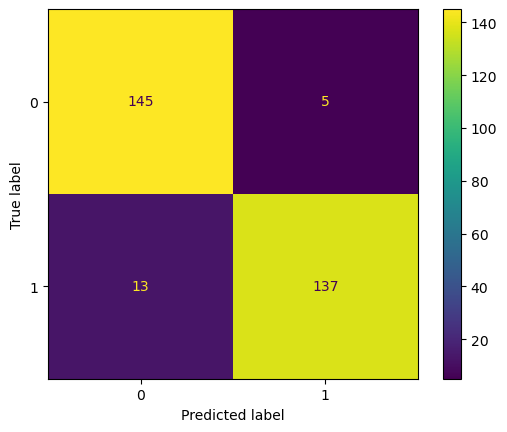

In [26]:
cm = confusion_matrix(y_test,y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=final_model.classes_)

plt.figure(figsize=(6,5))
disp.plot()
plt.savefig('confusion_matrix.png', dpi=200)
plt.show()

Berdasarkan model random forest kita ingin melihat bagaimana performa model kita secara mendetail. Untuk itu kita akan menggunakan confusion matrix.

Confusion matrix yang dihasilkan random forest sangatlah baik. Kita dapat melihat kesalahan prediksi (cell ungu) berjumlah sangat sedikit (bagian kanan atas dan kiri bawah).

Dengan hasil berikut maka kita akan mendapatkan akurasi, precision, dan recall yang bagus.

## 3.4 Feature Importance

In [27]:
feature_imp = {}

feature_imp['columns'] = X_train.columns
feature_imp['feature_imp'] = result2['model'][3].feature_importances_

In [28]:
df_feature_imp = pd.DataFrame(feature_imp)
df_feature_imp = df_feature_imp.sort_values(['feature_imp'],ascending=False).head(20)

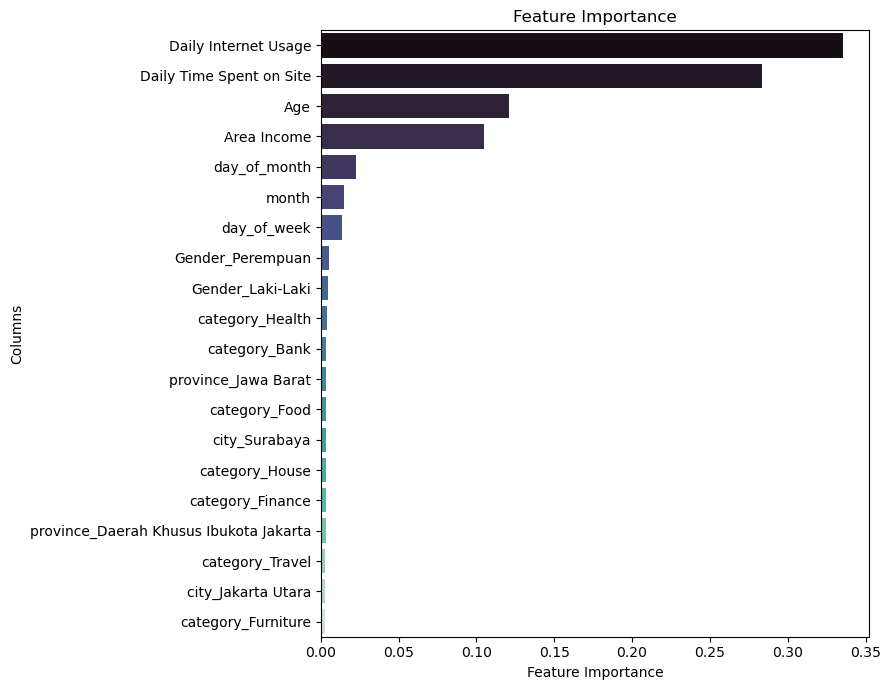

In [29]:
plt.figure(figsize=(9,7))
sns.barplot(x=df_feature_imp['feature_imp'],y=df_feature_imp['columns'], palette="mako")

plt.title('Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Columns')

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=200)
plt.show()

Dengan menggunakan model random forest kita mampu melihat feature yang paling penting dalam membangun model.

Berdasarkan metode random forest kita dapat melihat bahwa daily internet usage merupakan feature yang sangat penting dalam penentuan apakah user akan click atau tidak. Adapun feature penting lain adalah daily time spent on site, umur dan income suatu area.

Kalau kita combine insight yang kita peroleh dari proses EDA kita menjadi tahu bahwa ternyata penggunaan internet harian jika semakin tinggi maka peluang user akan click semakin kecil.

# 4. Business Recommendation

## 4.1 Feature Based

Berdasarkan EDA dan feature importance, kita dapat simpulkan bahwa:
1. Data yang kita dapatkan memiliki 2 segment user, yaitu segment user kelas atas dan kelas bawah.
    - Kelas atas memiliki kriteria sering menggunakan internet, sering mengunjungi website suatu product, memiliki umur yang relatif muda dan pendapatan yang tinggi.
    - Kelas bawah memiliki sifat sebaliknya.
2. User dengan kelas ekonomi bawah, cenderung lebih mudah tertarik untuk click product pada digital ads.
3. User yang sangat heavy dalam menggunakan internet justru lebih sulit untuk diberikan iklan karena mereka mungkin sudah terbiasa terhadap digital ads. 
4. Kalangan orang tua menjadi market yang potensial untuk market digital.

Business takeaway:
1. Kita bisa menggunakan cara yang lebih unik (soft selling) agar tidak begitu kelihatan beriklan oleh users.
2. Gunakan konten yang mainstream (sederhana tapi menjadi topic pembicaraan) agar bisa menggaet user dengan segment kelas bawah.

## 4.2 Model Based - Simulation

Dengan menggunakan model ML yang telah dibuat kita dapat membuat simulasi sebagai berikut:

Dengan asumsi:

* untuk beriklan terhadap seorang user bisa menggunakan budget **10rb rupiah**
* menggunakan data test sebagai alat simulasi sekitar 300 user dengan jumlah user pada masing-masing class sebanyak 150 user.
* Setiap user yang convert kita akan mendapatkan keuntungan sebesar **12rb rupiah**

In [30]:
# Ukuran data test
X_test.shape

(300, 65)

In [31]:
# Jumlah kelas pada setiap data
jum_class = pd.Series(y_test).value_counts()
jum_class

1    150
0    150
dtype: int64

Simulasi:

1. Tanpa Machine Learning Model
    * Kita akan menggunakan budget sekitar 300 * 10rb = 3jt rupiah untuk melakukan advertisement
        * **Cost=3jt**
    * Sedangkan conversion rate yang akan kita dapatkan sebanyak 50%
    * Karena hanya ada 150 yang convert maka kita akan mendapatkan 150 * 12rb = 1.8jt
        * **Revenue=1.8jt**
        * **Profit=1.8-3=-1.2jt**
    * Berdasarkan simulasi di atas jika kita tidak menggunakan machine learning model dan maka kita akan mendapatkan **potential loss sebesar 1.2jt rupiah**

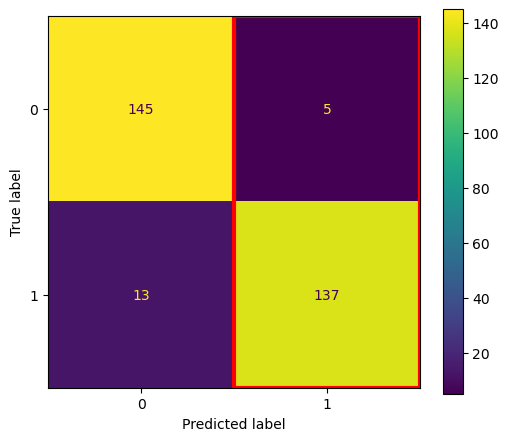

In [33]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(6,5))
disp.plot(ax=ax)

rect = patches.Rectangle((1-0.5, -0.5), 1, 2, linewidth=3, edgecolor='red', facecolor='none')
ax.add_patch(rect)

plt.show()

2. Dengan Menggunakan ML Model
    * Kita akan melakukan advertisement hanya pada user yang berpotensi clicked (yang kita prediksi 1)
    * Kita akan menggunakan budget sekitar 141 * 10rb = 1.41jt rupiah untuk melakukan advertisement
        * **Cost=1.41jt**
    * Sedangkan conversion rate yang akan kita dapatkan sebanyak 138/141 = 97.87%
    * Dari 146 yang kita prediksi akan ada 140 user yang convert
    * Maka kita akan mendapatkan 138 * 12rb = 1.65jt
        * **Revenue=1.65jt**
        * **Profit=1.65-1.41=240rb**
    * Berdasarkan simulasi di atas jika kita menggunakan machine learning model dan maka kita akan mendapatkan **potential revenue sebesar 240rb rupiah**